## Firms analysis

In [1]:
# importing dependencies

import s3fs
import pyarrow.parquet as pq
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import json
import duckdb

In [2]:
# defining matplotlib theme
plt.style.use('ggplot')
# setting up the duckdb
conn = duckdb.connect()

In [3]:
# loading s3 configurations
airflow_conns = json.load(open('../connections.json'))
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": airflow_conns['aws_s3_conn_id']['host'],
        "aws_access_key_id": airflow_conns['aws_s3_conn_id']['login'],
        "aws_secret_access_key": airflow_conns['aws_s3_conn_id']['password'],
    }
)

### Loading tables

- Firms
- Relations
- Shapes

In [4]:
# defining firms columns
columns = ['geometry', 'adm', 'adm4_name', 'adm6_name', 'adm7_name', 'datetime', 'month']
firms = pq.read_table("dutrajardim-fi/tables/firms/osm_adm8.parquet", filesystem=fs, columns=columns)

# defining relations columns
columns = ['adm4_name', 'id']
relations = pq.read_table("dutrajardim-fi/tables/shapes/osm/relations.parquet/adm=8", filesystem=fs, columns=columns)

shapes = pq.read_table("dutrajardim-fi/tables/shapes/osm/shapes.parquet/adm=8", filesystem=fs)

### Querying and plotting fire spots per month

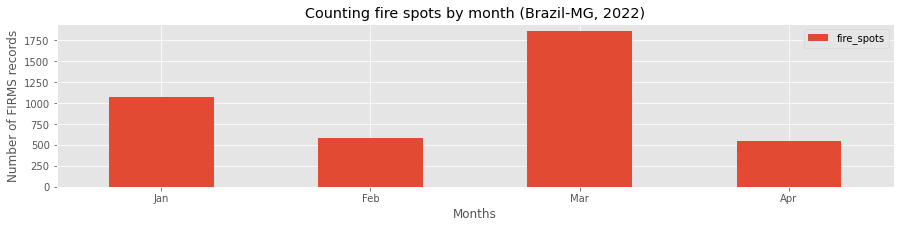

In [6]:
# defining the years for the query 
for year in range(2021, 2023):

    # querying fire spots per month
    fire_counts_by_month = conn.execute(f"""
    SELECT COUNT(*) AS fire_spots, STRFTIME(FIRST(datetime), '%b') as month_name, month
    FROM firms
    WHERE 
        adm4_name = 'Minas Gerais' AND 
        YEAR(datetime) = {year}
    GROUP BY month
    ORDER BY month ASC
    """).df()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,3))

    fire_counts_by_month.plot(
        kind="bar",
        title=f"Counting fire spots by month (Brazil-MG, {year})",
        xlabel="Months",
        ylabel="Number of FIRMS records",
        x="month_name",
        y="fire_spots",
        ax=ax,
        rot=0
    )

    # saving to docs folder
    fig.savefig(f"../docs/images/charts/BRA_MG/counting_fire_spots_by_month/{year}.svg") 
    
    # if is not the last year close without print
    if year != 2022:
        plt.close(fig)

### Querying and plotting fire spots per month (heatmap)

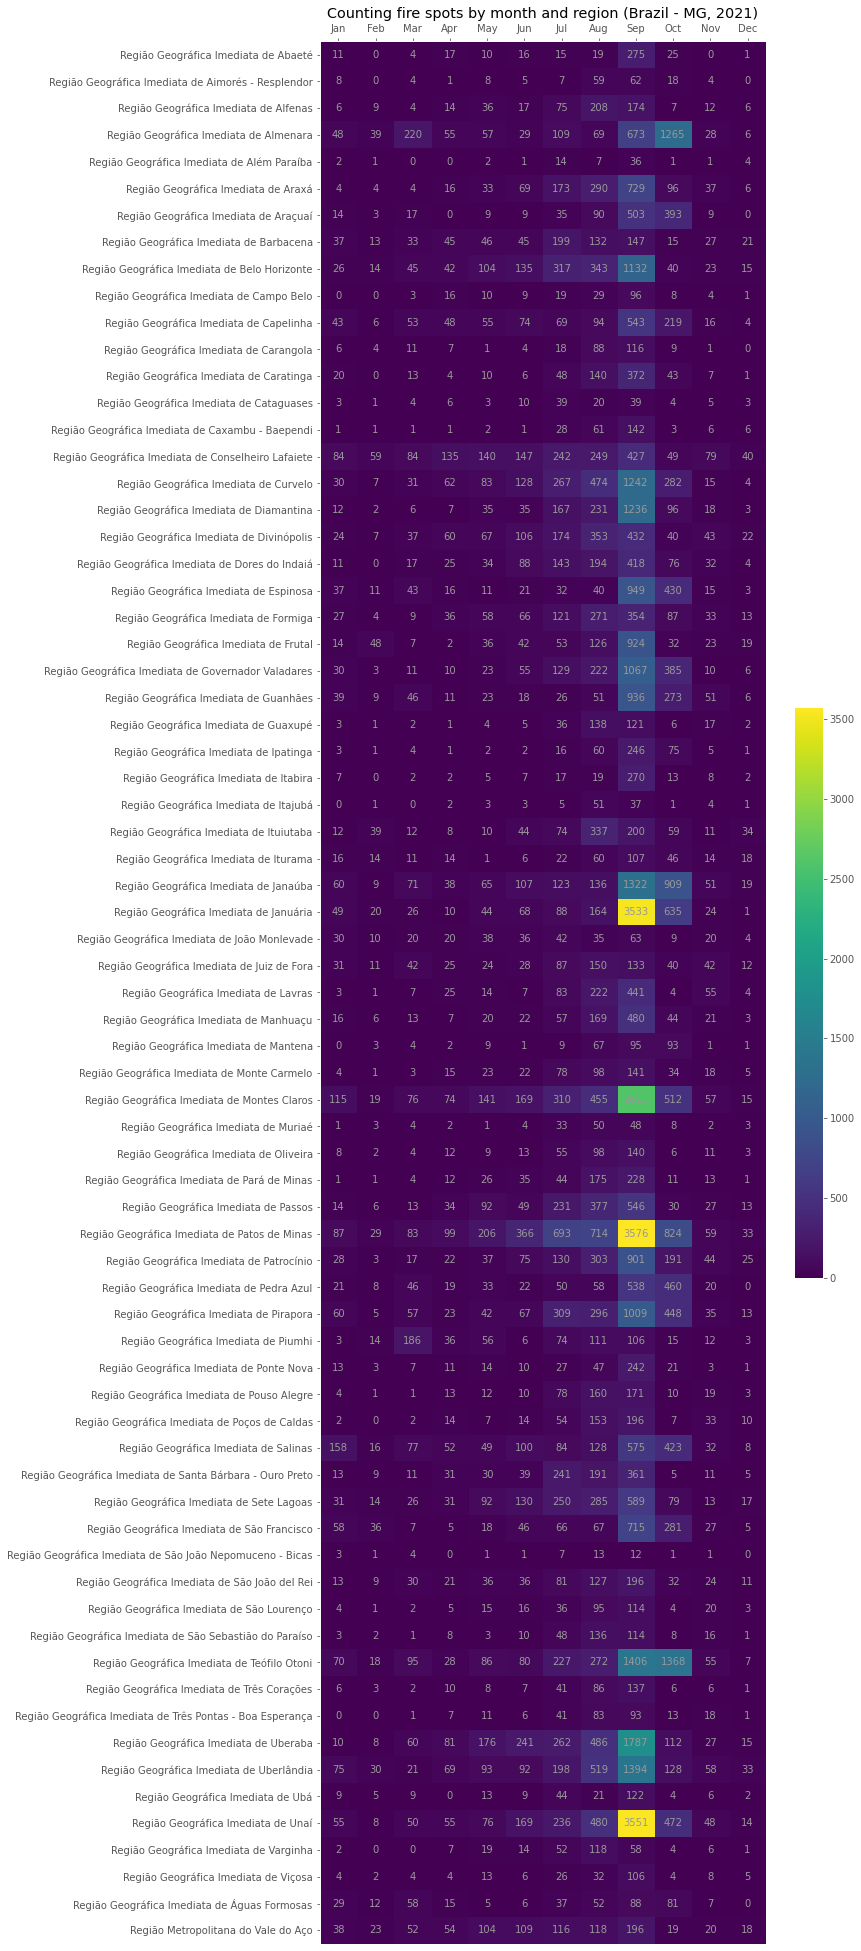

In [7]:
# removing grids to heatmap
plt.rcParams['axes.grid'] = False

# defining the years for the query 
for year in range(2021, 2023):

    # counting fire spots per month and by region
    # as city would be a lot of rows to plot with the 
    # heatmap
    counting_by_region_and_month = conn.execute(f"""
    SELECT 
        CASE WHEN adm7_name IS NOT NULL THEN adm7_name ELSE adm6_name END AS region, 
        COUNT(*) AS fire_spots, 
        STRFTIME(FIRST(datetime), '%b') as month_name, 
        month
    FROM firms
    WHERE 
        adm4_name = 'Minas Gerais' AND 
        YEAR(datetime) = {year}
    GROUP BY adm7_name, adm6_name, month
    ORDER BY month_name
    """).df()

    # creating a pivot table (month to column)
    pivot = ( 
        counting_by_region_and_month
        .pivot_table(index='region', columns=['month_name', 'month'], values='fire_spots', fill_value=0)
        .sort_index(axis=1, level='month')
    )

    fig, ax = plt.subplots(figsize=(10,35))

    im = ax.imshow(pivot.values, aspect='auto', interpolation='nearest')

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(pivot.columns)), labels=pivot.columns.get_level_values('month_name'))
    ax.set_yticks(np.arange(len(pivot.index)), labels=pivot.index)

    # Loop over data dimensions and create text annotations.
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            text = ax.text(j, i, pivot.values[i, j], ha="center", va="center", color="#999")


    ax.set_title(f"Counting fire spots by month and region (Brazil - MG, {year})")

    fig.colorbar(im, shrink=.3)
    
    # saving work to docs
    fig.savefig(f"../docs/images/charts/BRA_MG/counting_fire_spots_by_month_and_region/{year}.svg") 
    
    # if is not the last year close without print
    if year != 2021:
        plt.close(fig)

plt.rcParams['axes.grid'] = True

### Querying and plotting fire spots per city

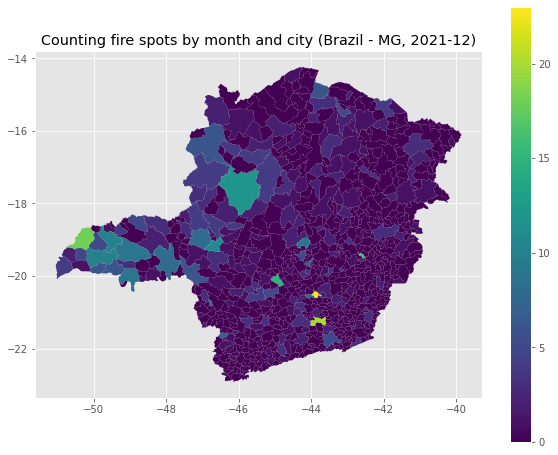

In [18]:
# defining year to query
year = 2021

# defining the months for the query
for month in range(1, 13):

    # counting fire spots for each shape in Minas Gerais
    monthly_fire_counts = conn.execute(f"""
    SELECT CASE WHEN fire_spots IS NOT NULL THEN fire_spots ELSE 0 END AS fire_spots, geometry
    FROM 
        (SELECT COUNT(*) AS fire_spots, adm
        FROM firms
        WHERE 
            adm4_name = 'Minas Gerais' AND 
            MONTH(datetime) = {month} AND
            YEAR(datetime) = {year}
        GROUP BY adm, month)
        
        counting
    
    RIGHT JOIN
        (SELECT shapes.id, shapes.geometry
        FROM shapes
        JOIN relations ON relations.id = shapes.id
        WHERE relations.adm4_name = 'Minas Gerais')
        
        shapes_mg
    
    ON counting.adm = shapes_mg.id
    """).df()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    ax.set_title(f"Counting fire spots by month and city (Brazil - MG, {year}-{month})")

    gdf_monthly_fire_counts = gp.GeoDataFrame(
        monthly_fire_counts, 
        geometry=gp.GeoSeries.from_wkt(monthly_fire_counts['geometry'])
    )
    gdf_monthly_fire_counts.plot(column='fire_spots', legend=True, ax=ax)

    # saving to docks folder
    fig.savefig(f"../docs/images/charts/BRA_MG/counting_fire_spots_by_city/year_{year}/month_{month}.svg")
    
    # if is not the last month close without print
    if month != 12:
        plt.close(fig)

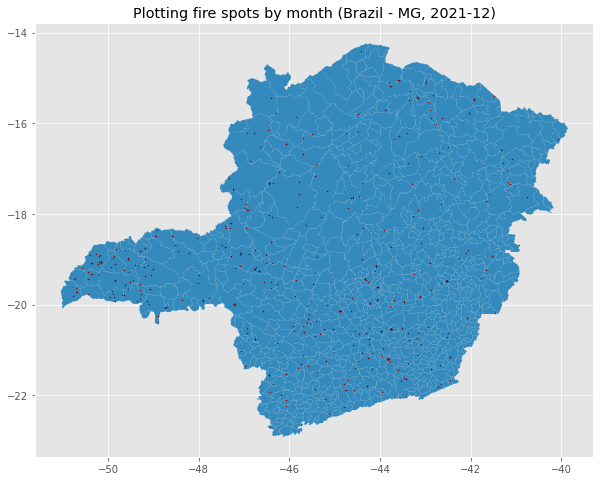

In [21]:
# defining year to query
year = 2021

# defining the months for the query
for month in range(1, 13):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    ax.set_title(f"Plotting fire spots by month (Brazil - MG, {year}-{month})")

    shapes_mg = conn.execute("""
    SELECT shapes.id, shapes.geometry
    FROM shapes
    JOIN relations ON relations.id = shapes.id
    WHERE relations.adm4_name = 'Minas Gerais'
    """).df()

    gdf_shapes_mg = gp.GeoDataFrame(
        shapes_mg.copy(), 
        geometry=gp.GeoSeries.from_wkt(shapes_mg['geometry'])
    )
    gdf_shapes_mg.plot(ax=ax)

    monthly_firms_mg = conn.execute(f"""
    SELECT geometry 
    FROM firms
    WHERE 
        adm4_name = 'Minas Gerais' AND
        MONTH(datetime) = {month} AND
        YEAR(datetime) = {year}
    """).df()

    gdf_monthly_firms_mg = gp.GeoDataFrame(
        monthly_firms_mg, 
        geometry=gp.GeoSeries.from_wkt(monthly_firms_mg['geometry'])
    )
    gdf_monthly_firms_mg.plot(ax=ax, color='darkred', markersize=.8)

    # saving to docs folder
    fig.savefig(f"../docs/images/charts/BRA_MG/plotting_fire_spots/year_{year}/month_{month}.svg") 
    
    # if is not the last year close without print
    if month != 12:
        plt.close(fig)